In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten


import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline 

#### Toy example for other scenarios where we have to deal with text

In [20]:
# define documents
docs = ['Well done!','Good work','Great effort',
    'nice work',]
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
max_length = 4
padded_docs = sequence.pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[2, 3], [4, 1], [5, 6], [7, 1]]
[[2 3 0 0]
 [4 1 0 0]
 [5 6 0 0]
 [7 1 0 0]]


### Now let us look at IMDB dataset which can be directly loaded through keras

In [3]:
# load the dataset but only keep the top n words, zero the rest
top_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [4]:
lengths = []
for i in X_train:
    lengths.append(len(i))

In [5]:
lengths[0:10]

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]

/Users/nikhildharap/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


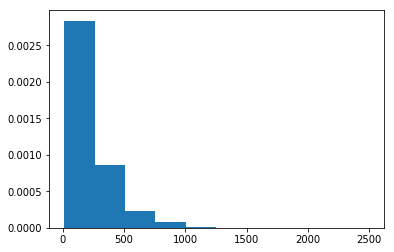

In [6]:
fig, ax = plt.subplots()
num_bins = 10
# the histogram of the data
n, bins, patches = ax.hist(lengths, num_bins, normed=1)

An approximate cut off will be 500

Truncate and pad input seq to make them same length

The model will learn that that the zero values mean nothing 

In [7]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [15]:
X_train.shape

(25000, 500)

In [10]:
#lets look at labels now
y_train[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [25]:
import keras
INDEX_FROM=3   # word index offset

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Reference: 

    1. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    2. https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
    
    Also look at - 
    https://paulx-cn.github.io/blog/4th_Blog/

In [8]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../LSTM_with_TF_Keras/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        print(e)
        print(line)
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

could not convert string to float: '.'
. . . -0.1573 -0.29517 0.30453 -0.54773 0.098293 -0.1776 0.21662 0.19261 -0.21101 0.53788 -0.047755 0.40675 0.023592 -0.32814 0.046858 0.19367 0.25565 -0.021019 -0.15957 -0.1023 0.20303 -0.043333 0.11618 -0.18486 0.0011948 -0.052301 0.34587 0.052335 0.16774 -0.21384 0.055947 0.24934 -0.12179 0.16749 0.28922 -0.033739 0.3015 -0.13241 0.092635 0.37155 -0.2884 -0.0052731 -0.001005 -0.51153 -0.28476 -0.20139 0.11837 -0.0055891 0.43604 0.16796 -0.2701 0.063957 -0.093253 -0.22079 0.36501 0.06545 0.23941 -0.19292 0.098293 0.12172 -0.1168 -0.027436 0.20507 -0.39139 -0.23111 0.46239 0.22888 -0.028415 -0.1798 0.23817 0.28093 -0.47935 0.23177 -0.35587 0.14246 0.11861 0.011018 0.091986 0.0054809 -0.39955 -0.40183 -0.10629 -0.30851 0.12383 -0.16737 -0.43569 0.4211 -0.57416 -0.19964 0.51312 0.090747 -0.21657 0.043519 0.24288 0.081134 0.49104 -0.33342 -0.31056 -0.3136 0.26931 -0.14402 0.33185 -0.21662 -0.072985 0.080603 -0.7266 -0.098385 -0.36233 -0.25346 0.1154

could not convert string to float: '.'
. . 0.035974 -0.024421 0.71402 -0.61127 0.012771 -0.11201 0.16847 -0.14069 -0.053491 -0.87539 -0.13959 0.29731 0.072308 -0.084514 -0.1879 0.12358 0.37639 -0.39238 -0.01111 -0.04924 0.63649 0.058814 0.19076 -0.20828 -0.11036 0.14934 0.24667 -0.39438 0.22853 -0.11201 0.33539 -0.32929 -0.049727 -0.090764 0.29095 0.27504 0.22802 -0.15616 0.37302 0.3752 -0.3677 0.1518 -0.27551 -0.63281 -0.31298 -0.22441 -0.15435 -0.64802 0.28404 0.12356 0.0034255 0.03094 0.35345 -0.46781 0.59203 -0.17966 0.27702 -0.46738 0.19438 0.21939 -0.36743 -0.084781 0.03253 -0.51323 -0.55466 0.49585 0.066985 0.47906 -0.25118 0.011123 0.15605 -1.0761 0.60875 -0.15764 0.066122 0.12779 -0.089209 0.4311 0.045732 -0.29364 -0.19994 -0.065952 0.26236 0.34039 -0.4956 -0.41187 0.055566 -0.69902 -0.057696 0.76519 0.2018 -0.34497 -0.22707 0.34316 -0.16098 0.42469 0.0080257 -0.33017 -0.43485 0.23581 -0.71085 0.27985 -0.31261 -0.012817 0.48305 -0.75151 -0.02347 -0.39653 -0.86857 0.2877 0.2667

KeyboardInterrupt: 